# Example 2: Simulating the Earliest Possible Sowing Date for Millet in Niger using different satellite rainfall estimation products, and comparing with observed sowing dates

basé sur la première version du notebook qui prend en compte iSDA

The aim of this notebook is to help determine, for each satellite rainfall estimation product in between TAMSAT, CHIRPS, IMERG and PrISM, which threshold value for surface water stock should be used in order to best represent the variability in the mean sowing dates per department as declared through the LSMS-ISA permanent agricultural survey.

For this, we first perform a simulation run with each of the satellite rainfall estimation product. Then, we apply different threshold values to the surface water stock and compare the resulting mean sowing dates per department with the LSMS-ISA data. This will allow to determine the best threshold value for each satellite rainfall estimation product, and the overall best satellite rainfall estimation product to use for this exercice.

In this notebook, we will work on determining the surface water stock threshold to use in subsequent analyses.

## Imports

In [21]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import io
import xarray as xr
from sarra_py import *
import time
import geopandas as gpd
from scipy.stats import pearsonr
import plotly.express as px
import warnings

## Preparing simulation

In [3]:
date_start = datetime.date(2014,1,1)
duration = 220

## Simulation parameters

In [4]:
# weather and rainfall data path
rainfall_data_path_TAMSAT = "/mnt/d/climate_database/TAMSAT_v3.1_niger_rfe_filled_1983_2021_DL20230614/" 
rainfall_data_path_CHIRPS = "/mnt/d/climate_database/CHIRPS_v2.0_Africa_niger/"  
rainfall_data_path_IMERG = "/mnt/g/Mon Drive/CIRAD/draft paper sowing date satellite rainfall products/data/rfe/IMERG_niger_band_data/" 
rainfall_data_path_PrISM = "/mnt/g/Mon Drive/CIRAD/draft paper sowing date satellite rainfall products/data/rfe/PrISM_niger" 

rainfall_data_paths = {"TAMSAT": rainfall_data_path_TAMSAT, 
                       "CHIRPS": rainfall_data_path_CHIRPS,
                       "IMERG": rainfall_data_path_IMERG,
                       "PrISM": rainfall_data_path_PrISM}

climate_data_path = "/mnt/d/climate_database/AgERA5_niger_1981_2021_DL20230615/"

# parameter files
file_paramVariete = "millet_variety.yaml"
file_paramITK = "millet_niger_2017.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# simulation parameters
date_start = datetime.date(2014,1,1)
duration = 220 # days

## Running the simulations

In [5]:
# initialize a dictionary to store simulation results
simulation_output = {}

# as we want to study the variation of sowing date using different satellite rainfall estimates, we perform one simulation per rainfall dataset
for rainfall_data_name in tqdm(rainfall_data_paths):

    # setting the data path according to the rainfall dataset
    rainfall_data_path = rainfall_data_paths[rainfall_data_name]

    # retrieving the grid size from the rainfall data (this method will be deprecated in the future)
    grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration)

    ## preparing the base dataset
    # initialize empty xarray dataset to load base data
    base_data = xr.Dataset()

    # load rainfall and weather data
    base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration)
    base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration)

    # load soil data using the iSDA method (uses more recent maps)
    base_data = load_iSDA_soil_data_alternate(base_data, grid_width, grid_height)

    # compute the day length
    base_data = calc_day_length_raster_fast(base_data, date_start, duration)    

    ## prepating simulation dataset
    # load variety, cropping system and soil parameters
    paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

    # creating simulation xarray dataset by copying the base data
    data = base_data.copy()

    # initializing all the necessary variables
    data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
    data = initialize_default_irrigation(data)
    data = calculate_once_daily_thermal_time(data, paramVariete)

    ## running the model
    data = run_waterbalance_model(paramVariete, paramITK, paramTypeSol, data, duration)

    # storing the results in a dictionary
    simulation_output[rainfall_data_name] = data["surface_tank_stock"]

    # free memory
    del base_data, data

100%|██████████| 4/4 [11:03<00:00, 165.97s/it]


## Visualizing some results

Let's plot some results to see what we have done. Starting with dynamics of surface tank stock.

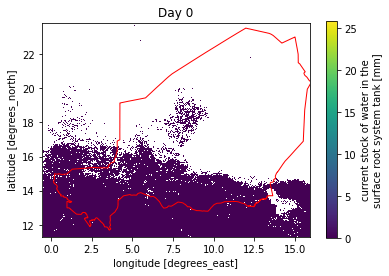

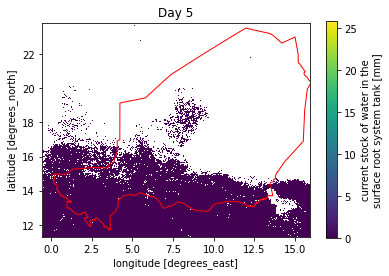

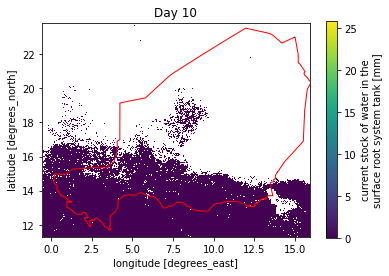

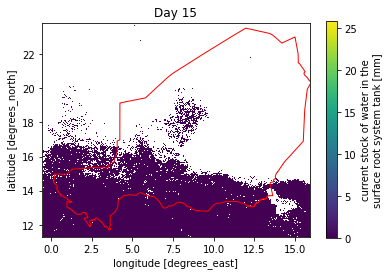

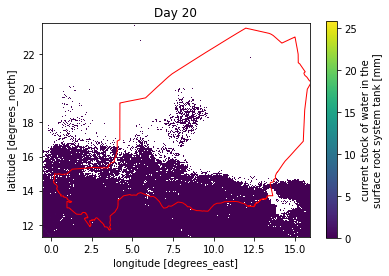

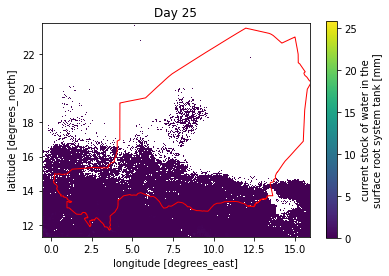

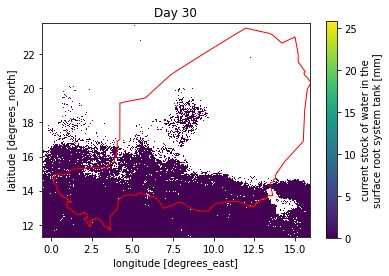

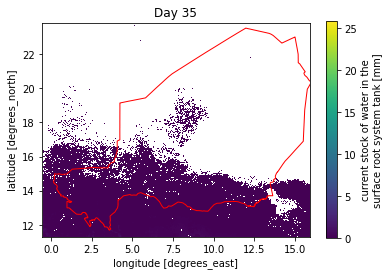

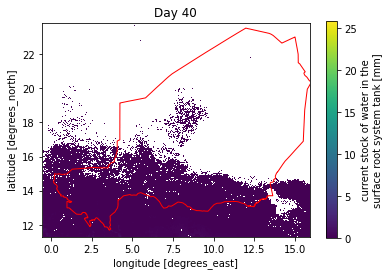

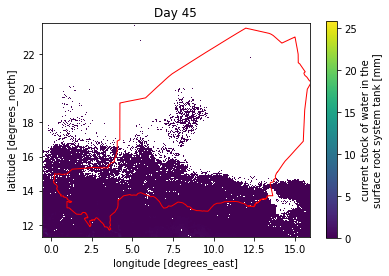

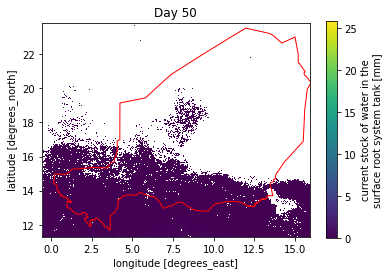

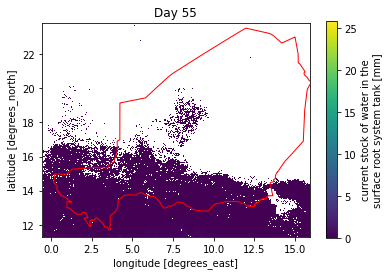

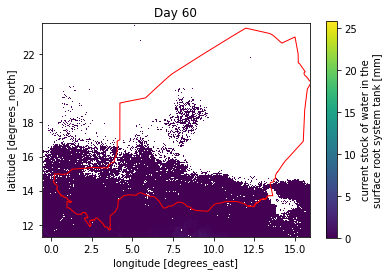

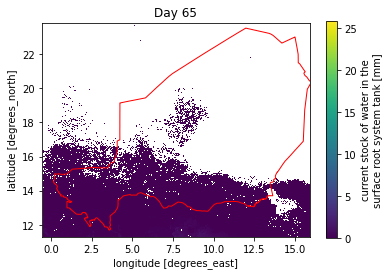

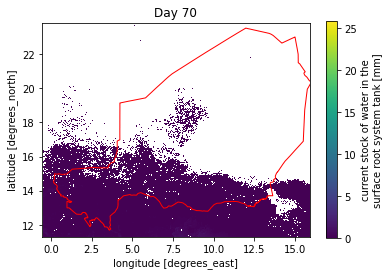

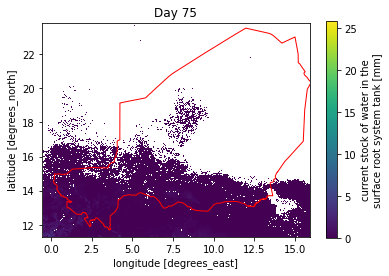

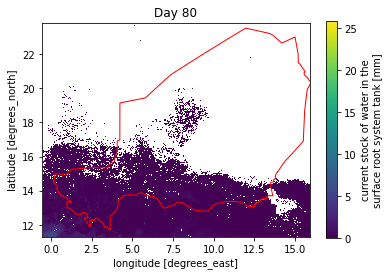

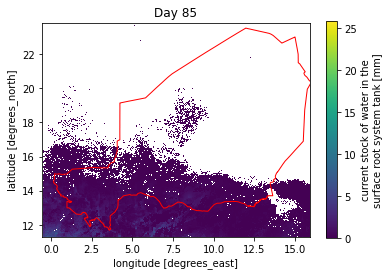

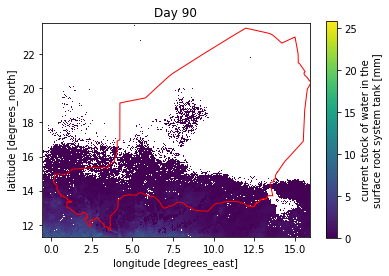

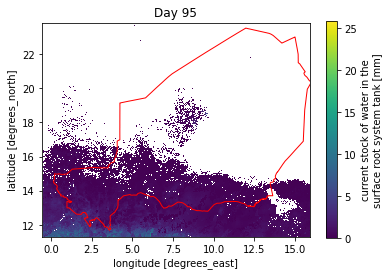

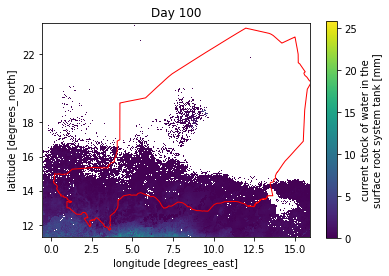

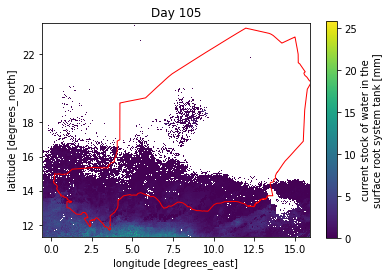

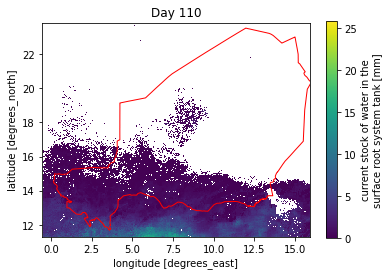

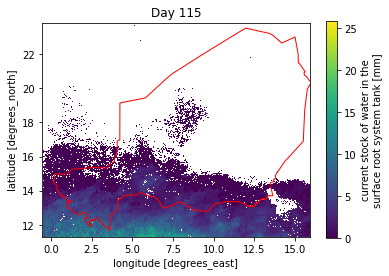

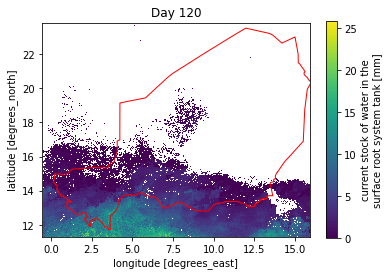

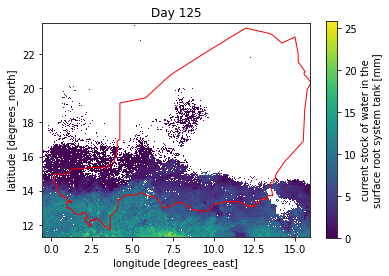

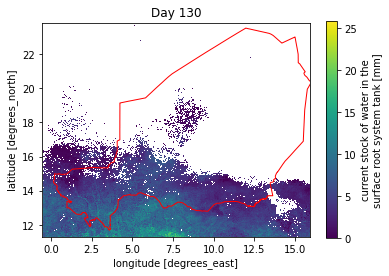

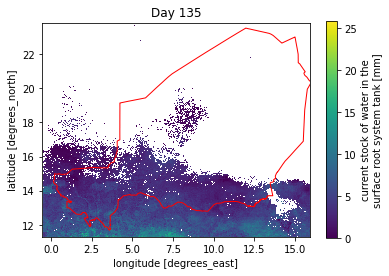

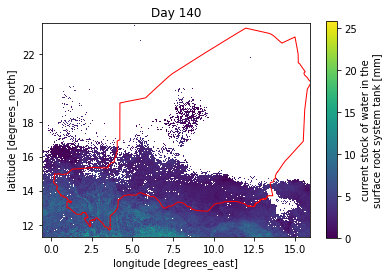

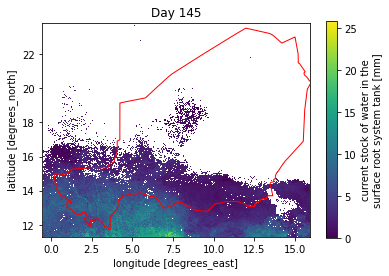

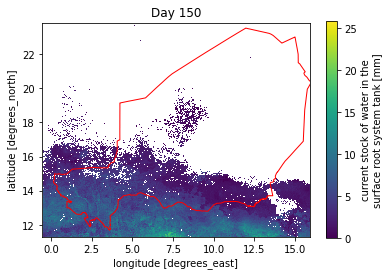

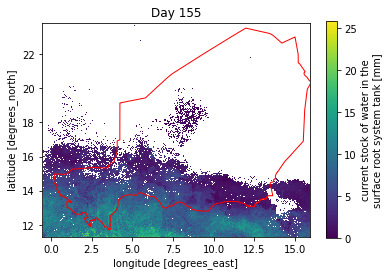

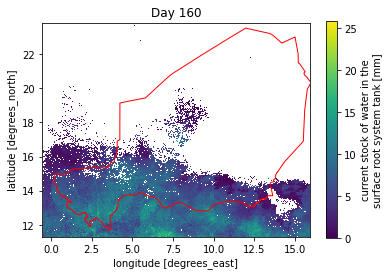

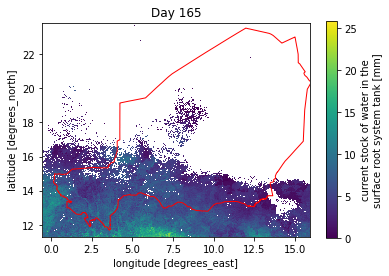

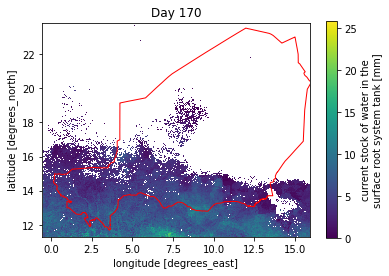

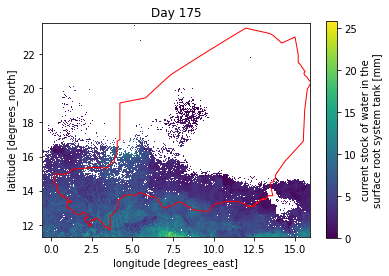

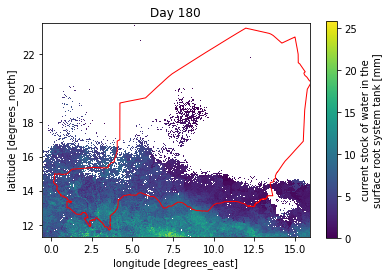

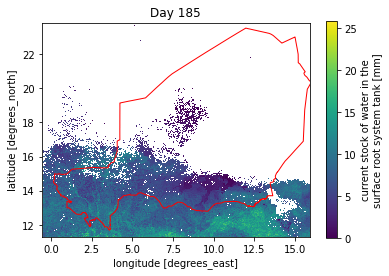

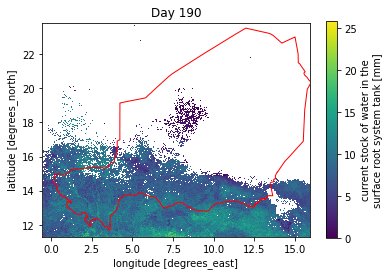

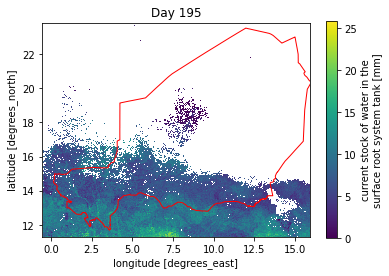

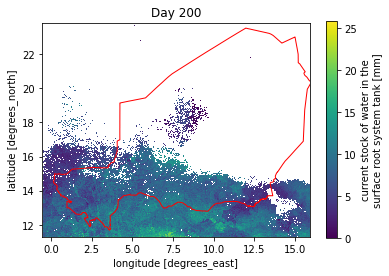

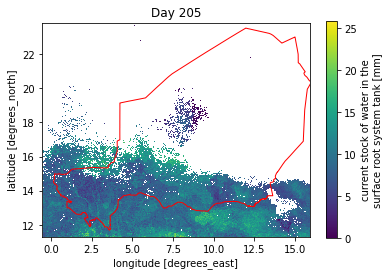

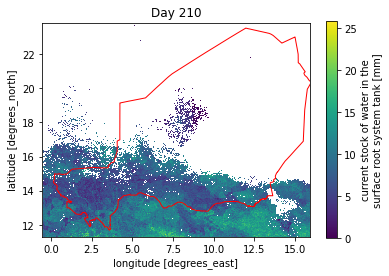

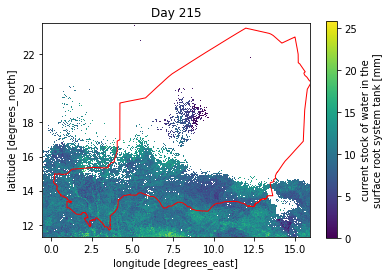

In [9]:
rainfall_data_name = "CHIRPS"
time_resolution = 5

vmax = simulation_output[rainfall_data_name].max().values
gdf = gpd.read_file("https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_NER_shp.zip")
for i in range(int(round(duration/time_resolution,0))):
    simulation_output[rainfall_data_name][time_resolution*i,:,:].plot(vmin=0, vmax=vmax)
   
    gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
    plt.title("Day %s" % (i*time_resolution))
    plt.show()

Create a map of the first day at which the surface tank reaches a given threshold

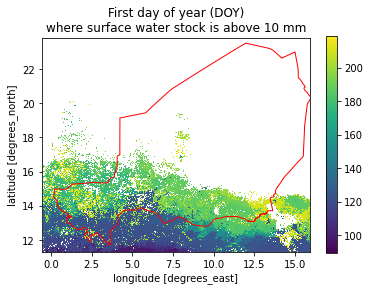

In [16]:
rainfall_data_name = "CHIRPS"
threshold = 10 # mm

# creates a map of the first day at which the surface tank reaches the threshold
# argmax returns the index of the first True value along the time axis, that is here the DOY as simulation started on Jan. 1st
argmax = (simulation_output[rainfall_data_name] > threshold).argmax(axis=0)
result = xr.where(argmax==0,np.nan,argmax)

# hide the original variable name
result.name = None

# rename the axes
result = result.rename({'x':'longitude [degrees_east]','y':'latitude [degrees_north]'})
result.plot()

# draw the country borders
gdf = gpd.read_file("https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_NER_shp.zip")
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)

# add title
plt.title("First day of year (DOY)\nwhere surface water stock is above {} mm".format(threshold))

# display figure
plt.show()

## Compare the estimated sowing date with the observed sowing date at department level from the LSMS-ISA data

Our observed sowing date values have been produced by crunching the numbers in the 2014 LSMS-ISA data for Niger. We calculated the mean date for each departement for successful millet sowing. 

In [76]:
# load administrative boundaries for Niger departements (ADM2 level)
departments_gdf = gpd.read_file("../notebooks/exemple_2_satellite_rainfall_sowing_date/ner_adm02_feb2018/NER_adm02_feb2018.shp")

# load observed values for mean first plausible sowing date per department
observed_sowing_dates_df = pd.read_csv("../notebooks/exemple_2_satellite_rainfall_sowing_date/department_means.csv",sep=",",encoding="utf-8")

In [77]:
# deactivate FutureWarnings for frame.append method for nicer output
warnings.simplefilter(action='ignore', category=FutureWarning)

# creating empty dataframe to store comparison results
result_df = pd.DataFrame()

# for each rainfall product
for rainfall_data_name in tqdm(rainfall_data_paths) :
    
    # and for different surface tank stock thresholds
    for threshold in tqdm(np.arange(1, 21, 0.5)):
        
        # we create a map of the first day at which the surface tank reaches the
        # threshold argmax returns the index of the first True value along the
        # time axis, that is here the DOY as simulation started on Jan. 1st
        argmax = (simulation_output[rainfall_data_name] > threshold).argmax(axis=0)
        result = xr.where(argmax == 0, np.nan, argmax)

        # we add the coordinate reference system (CRS) info, which is necessary for the clip method
        result = result.rio.set_crs(4326)

        # for each department
        for i in range(len(departments_gdf)):

            # we compute the mean value for the DOY when the surface tank stock
            # is above the threshold and we store the result in the
            # departments_gdf dataframe
            departments_gdf.loc[i, "estimated_onset_doy"] = result.rio.clip(gpd.GeoSeries(departments_gdf.iloc[i].geometry)).mean().values

        # we combine the departments_gdf and observed_sowing_dates_df together
        # so we have the observed sowing date and the simulated sowing date in
        # the same dataframe
        departments_gdf_merged = departments_gdf.merge(observed_sowing_dates_df, left_on="adm_02", right_on="Department")

        # we compute the Pearson correlation between the observed and simulated
        # sowing dates
        try:
            pearson = pearsonr(departments_gdf_merged["estimated_onset_doy"], departments_gdf_merged["caseB"])
        except:
            pearson = (np.nan, np.nan)

        # we store the result in the result_df dataframe
        result_df = result_df.append({"rainfall_data_name":rainfall_data_name,
                                        "surface_tank_stock_thres": threshold,
                                        "statistic": pearson[0],
                                        "pvalue":pearson[1]}, ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [43]:
# we plot the correlation between the sowing date and the surface tank stock threshold
# for the 3 rainfall datasets
fig = px.line(result_df, x="surface_tank_stock_thres", y="statistic", color="rainfall_data_name",
            title="Correlation between the observed sowing date and the estimated sowing date\nusing different surface tank stock thresholds")
#rename yaxis
fig.update_yaxes(title_text="Pearson correlation coefficient")
#rename xaxis
fig.update_xaxes(title_text="Surface tank stock threshold (mm)")
fig.show()

We can see that when performing aggregation at the department level, it seem possible and preferable to use the CHIRPS dataset rather than other satellite rainfall estimation products to estimate sowing dates as its correlation with mean observed sowing date is the highest. Also, the threshold value at which the correlation is the highest is 9 mm (r=0.80, thus explaining 64% of the observed variability) ; this means that the simulated water stock in the surface layer of the soil should be at least 9 mm to best represent the observed sowing date.

If we want to plot the OLS so we can have an idea of its coefficient and intercept, we can use the following code:

## Fitting a correction model

In [74]:
rainfall_data_name = "CHIRPS"
threshold = 9 # mm

# re-running the code used to produce the departments_gdf_merged result dataframe
argmax = (simulation_output[rainfall_data_name] > threshold).argmax(axis=0)
result = xr.where(argmax == 0, np.nan, argmax)
result = result.rio.set_crs(4326)
for i in range(len(departments_gdf)):
    departments_gdf.loc[i, "estimated_onset_doy"] = result.rio.clip(gpd.GeoSeries(departments_gdf.iloc[i].geometry)).mean().values
departments_gdf_merged = departments_gdf.merge(observed_sowing_dates_df, left_on="adm_02", right_on="Department")

# computing the OLS with plotly and displatying the result
fig = px.scatter(departments_gdf_merged, x="estimated_onset_doy", y="caseB", trendline="ols")
# add the name of the points
fig.update_layout(width=600, height=500)
fig.show()


In [69]:
# fitting the OLS model
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()

# getting the slope and intercept of the OLS trendline
intercept, slope = results.px_fit_results.iloc[0].params[0], results.px_fit_results.iloc[0].params[1]

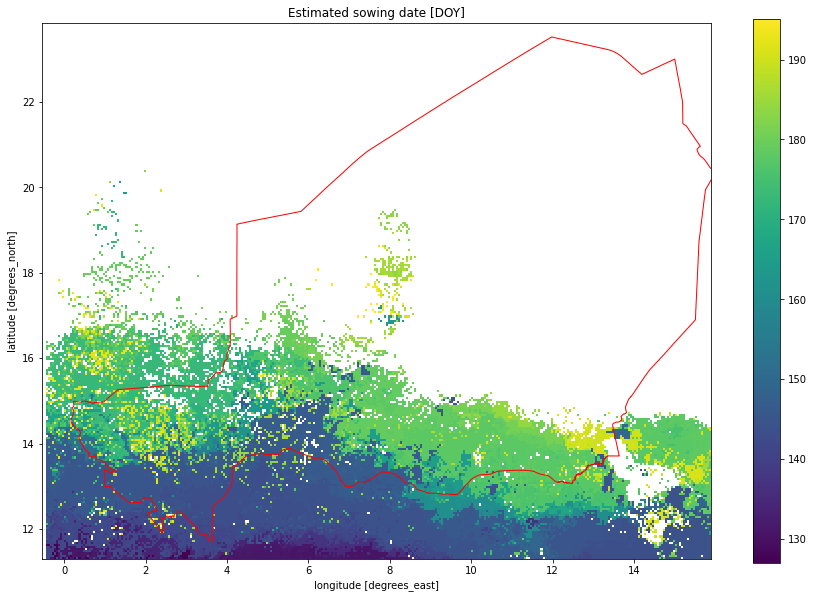

In [75]:
rainfall_data_name = "CHIRPS"
threshold = 9 # mm

# creates a map of the first day at which the surface tank reaches the threshold
# argmax returns the index of the first True value along the time axis, that is here the DOY as simulation started on Jan. 1st
argmax = (simulation_output[rainfall_data_name] > threshold).argmax(axis=0)
result = xr.where(argmax==0,np.nan,argmax)

# correcting the estimations using the fitted slope and intercept
result = slope * result + intercept

# hide the original variable name
result.name = None

# rename the axes
result = result.rename({'x':'longitude [degrees_east]','y':'latitude [degrees_north]'})

# increase plot size
plt.figure(figsize=(15,10))

# plot the result
result.plot()

# draw the country borders
gdf = gpd.read_file("https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_NER_shp.zip")
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)

# add title
plt.title("Estimated sowing date [DOY]")

# display figure
plt.show()